# Packages

In [1]:
import ee
import geemap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Open Nighttime Lights\\06_Data Fusion for Image Classification'

Now that we have processed and explored our data, we will try to classify built-up areas with a Random Forest ensemble of decision trees.

Decision tree models like Random Forest are among the most powerful, easy to use, and simple to understand models in the machine learning portfolio.

# Training Data

In [2]:
# define some functions and variables
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)


se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

# create training data
roi = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME','Bagmati')).geometry()

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median().select(se2bands).clip(roi)

viirs = ee.Image(ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2019-12-31").filterBounds(roi).median().select('avg_rad').clip(roi))

fused = se2.addBands(viirs)

# create and overlay labels to training data
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    '2015-01-01', '2015-12-31')).select(label).median().gte(2).clip(roi)

points = ghsl.sample(**{"region":roi, "scale":scaleFactor,"seed":0,'geometries':True})

data = fused.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# Look at the stats
data.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.18796029458853666,
 'min': 0,
 'sample_sd': 0.39071173874702697,
 'sample_var': 0.15265566279472506,
 'sum': 1174,
 'sum_sq': 1174,
 'total_count': 6246,
 'total_sd': 0.39068046053869543,
 'total_var': 0.15263122224672718,
 'valid_count': 6246,
 'weight_sum': 6246,
 'weighted_sum': 1174}

In our total training dataset, we have 6,246 observations and our label clasification shows that about 19% (the mean value above) of our data are classified as built-up (1) with the rest not.

# Cross-validation

Cross-validation is one of the most important aspects of machine learning development. Last section we talked about several attributes of the training data that may impact classification:
- varying spatial resolution and choices for re-sample rate
- choices about data cleaning
- decisions about which bands to include

We also may decide to create new features (known as feature engineering) by transforming our data sources mathmatically (getting derivatives, information about neighboring pixels, etc) or even fusing additional data.

The classification algorithm itself will have hyperparameters than may be adjusted (known as hyperparameter tuning). How do we decide these things?

Often we will experiment empirically and see what works, this is a big advantage to advances in computing resources and machine learning packages. However, if we just tweak our data until we get the best performance on our training data and leave it at that, we are at risk of over-fitting our model.

Over-fitting a model means making it too specific to our data on-hand in a way that will fail us on unseen data. This could impact the final analysis and ultimately stakeholder trust and their ability to make informed decisions, so we want to think about strategies to avoid this. That is our situation here: since we dont have any “ground truth” for our data after 2015 in terms of settlements, we will want to validate our classifier as best we can with the labeled data we have before “releasing it to the wild.”

A key way to do that is to split our labeled data into two components: training and testing sets (or even train, validation and test sets). There are many strategies for this, including a K-fold sample technique (or a stratified K-Fold technique, which addresses the class imbalance issue we noted earlier). Unfortunately things can get quite complex with time series or sequential data (since observations in time are “dependent” on observations before, we cannot fairly randomly split them).

For our purposes, a simple 80/20 train/test split randomly among the pixels in our 2015 training image will be fine, but this is another great topic to learn more about.

In [3]:
# We'll create a column of random numbers
data = data.randomColumn(seed = 42)
split_thresh = 0.8

train = data.filter(ee.Filter.lt('random', split_thresh))
test = data.filter(ee.Filter.gte('random', split_thresh))

train.aggregate_stats(label).getInfo(), test.aggregate_stats(label).getInfo()

({'max': 1,
  'mean': 0.18225709112854557,
  'min': 0,
  'sample_sd': 0.3860951070365603,
  'sample_var': 0.14906943167757297,
  'sum': 906,
  'sum_sq': 906,
  'total_count': 4971,
  'total_sd': 0.3860562703310317,
  'total_var': 0.1490394438619066,
  'valid_count': 4971,
  'weight_sum': 4971,
  'weighted_sum': 906},
 {'max': 1,
  'mean': 0.21019607843137256,
  'min': 0,
  'sample_sd': 0.40760764965829877,
  'sample_var': 0.16614399605996244,
  'sum': 268,
  'sum_sq': 268,
  'total_count': 1275,
  'total_sd': 0.4074477721665009,
  'total_var': 0.16601368704344482,
  'valid_count': 1275,
  'weight_sum': 1275,
  'weighted_sum': 268})

We have ~5,000 observations (pixels) in our training set and ~1,200 in our test set.

And notice balance of our label is similar for training and testing (~18% and ~20% classified as built-up, respectively), which we’d expect in a random split.

# Train the classifier

In [4]:
init_params = {
    'numberOfTrees': 100,       # Number of individual decision tree models
    'variablesPerSplit': None,  # Number of features to use per split
    'minLeafPopulation': 1,     # Smallest sample size possible per leaf
    'bagFraction': 0.5,         # Fraction of data to include for each individual tree model
    'maxNodes': None,           # Max Number of leafs/nodes per tree
    'seed': 42                  # Random seed for "random" choices like sampling
}

clf = ee.Classifier.smileRandomForest(**init_params).train(train, label, trainingbands)
clf

# Evaluation

We need metrics to determine how well the classifier performs. We just have a simple binary schema so we can visaulize a confusion matrix, which shows the actual labels (y axis) and the predicted labels (x axis).

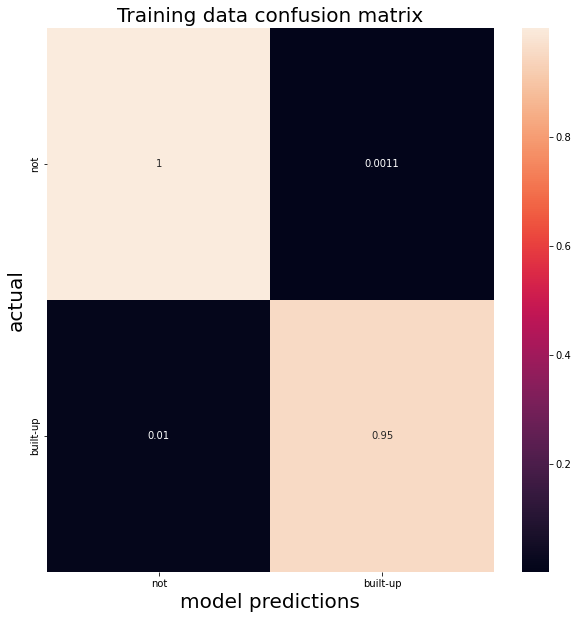

In [5]:
trainResults = clf.confusionMatrix().getInfo()
trainCM = pd.DataFrame(np.asarray(trainResults), index = ['not', 'built-up'], columns = ['not', 'built-up'])

fig, ax = plt.subplots(1, figsize = (10, 10))
sns.heatmap(trainCM / trainCM.sum(axis = 1), annot = True)

ax.set_xlabel('model predictions', fontsize = 20)
ax.set_ylabel('actual', fontsize = 20)
plt.title('Training data confusion matrix', fontsize = 20)
plt.show()

The matrix shows True Negatives (top left), False Positives (top right), True Positives (bottom right) and False Negatives (bottom left). Accuracy measures the ratio of hits for both positive (built up) and negative (not) classes.

$$ ACC = \frac{TP + TN}{TP + TN + FP + FN} $$

In [6]:
acc = (trainCM.loc['built-up', 'built-up'] + trainCM.loc['not', 'not']) / trainCM.sum().sum()

print(f"Our classifier has an accuracy of {acc:.5f} on the training data.")

Our classifier has an accuracy of 0.99155 on the training data.


With a balanced class (~50% built up and 50% not), this metric might be ok, assuming we didnt care at all about false positives or negatives. But accuracy is not a great metric.

Consider an extreme (but realistic) example where 1 out of 100 observations are in the positive class. A classifier could predict that everything is negative and be right 99 of 100 times…99% accuracy might be considered good, but there is no predictive power here and no information is yielded. If you do care about false negatives (say, if the test is for a disease or something with high stakes) you do not want a classifier that just predicts negatives naively: 1 miss in 100 could be terrible for real world consequences.

For binary classification there are many options. The Matthews correlation coefficient (based on Pearson’s phi coefficient) is a better score, so let’s use that.

$$ MCC = \frac{TP * TN - FP * FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}} $$

In [7]:
def get_mcc(cm, pos_label='built-up',neg_label='not'):
    tp = cm.loc[pos_label, pos_label]
    tn = cm.loc[neg_label, neg_label]
    fn = cm.loc[pos_label, neg_label]
    fp = cm.loc[neg_label, pos_label]
    
    return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))

mcc = get_mcc(trainCM)
print(f"Our classifier has an MCC score of {mcc:.5f} on the training data.")

Our classifier has an MCC score of 95.46896 on the training data.


C:\Users\gilramolete\AppData\Local\Temp\ipykernel_34116\4105784805.py:7: RuntimeWarning: overflow encountered in scalar multiply
  return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))


# Test Results

Either way, the performance seems good, but remember this is the data we trained the classifier on, so it really just learned about this specific data. Never base your model evaluation on your training data alone!

We need to look at the out sample that it was not trained on to get a better indication of how this classifier will do on unseen data, which is what we are relying on to get accurate predictions of 2016 through 2019 land use classification.

Our classifier has an accuracy of 0.89961 on the test data.
Our classifier has an MCC score of nan on the test data.


C:\Users\gilramolete\AppData\Local\Temp\ipykernel_34116\4105784805.py:7: RuntimeWarning: overflow encountered in scalar multiply
  return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))
C:\Users\gilramolete\AppData\Local\Temp\ipykernel_34116\4105784805.py:7: RuntimeWarning: invalid value encountered in sqrt
  return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))


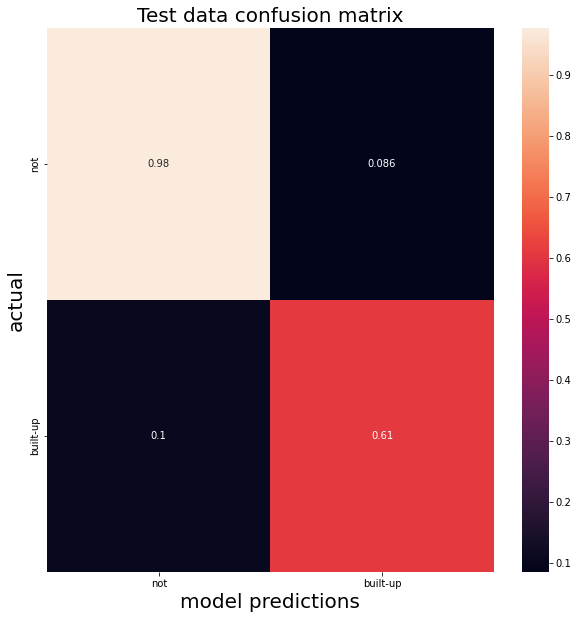

In [8]:
testResults = test.classify(clf).errorMatrix(label, 'classification').getInfo()
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data confusion matrix", fontsize=20);
acc = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
mcc = get_mcc(testCM)
print(f"Our classifier has an accuracy of {acc:.5f} on the test data.")
print(f"Our classifier has an MCC score of {mcc:.5f} on the test data.")

We can see the difference in the confusion matrix and in the lower accuracy – and far lower MCC scores. On unseen data, our classifier seems to be over-predicting built up areas and producing a lot of false positives. This might impact our final analysis…this over-prediction translates into a final assessment of increased economic growth that might be in error.

Let’s see if increasing he number of estimators (trees) in our ensemble improves things on our test data results.

In [9]:
new_params = {"numberOfTrees":500, 
              "variablesPerSplit":None,  
              "minLeafPopulation":1, 
              "bagFraction":0.5, 
              "maxNodes":None, 
               "seed":0}

clf2 = ee.Classifier.smileRandomForest(**new_params).train(train, label, trainingbands)
clf2

Our classifier has an accuracy of 0.89804 on the test data.
Our classifier has an MCC score of 3.79976 on the test data.


C:\Users\gilramolete\AppData\Local\Temp\ipykernel_34116\4105784805.py:7: RuntimeWarning: overflow encountered in scalar multiply
  return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))


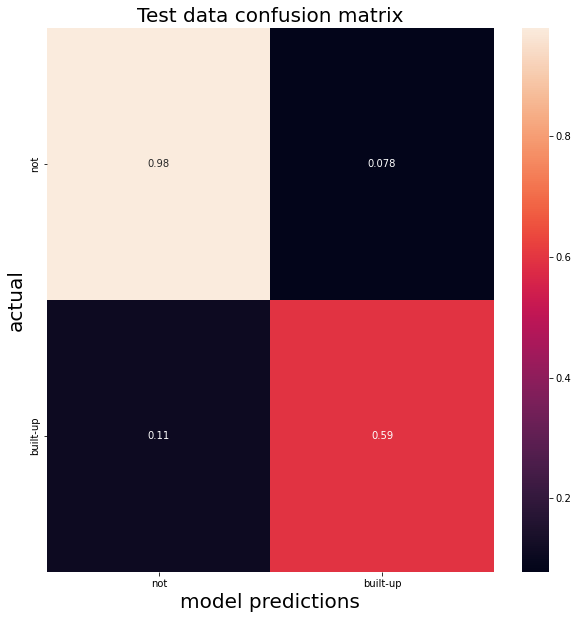

In [10]:
testResults = test.classify(clf2).errorMatrix(label, 'classification').getInfo()
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data confusion matrix", fontsize=20);
acc = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
mcc = get_mcc(testCM)
print(f"Our classifier has an accuracy of {acc:.5f} on the test data.")
print(f"Our classifier has an MCC score of {mcc:.5f} on the test data.")

…it’s about the same.

If you spend a lot of time with machine learning algorithms, you will see that model tuning at best usually delivers incremental results. But thinking more about the data that is put into the model (feature engineering, additional sources, etc) is usually more likely to imrpove your model.

What happens when we try cleaning the data like we did before by standardizing the VIIRS-DNB band?

Our classifier has an accuracy of 0.89717 on the test data.
Our classifier has an MCC score of nan on the test data.


C:\Users\gilramolete\AppData\Local\Temp\ipykernel_34116\4105784805.py:7: RuntimeWarning: overflow encountered in scalar multiply
  return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))
C:\Users\gilramolete\AppData\Local\Temp\ipykernel_34116\4105784805.py:7: RuntimeWarning: invalid value encountered in sqrt
  return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))


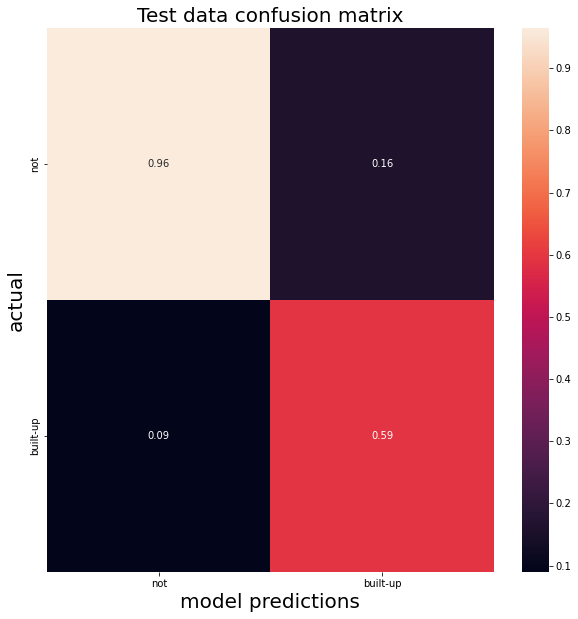

In [11]:
vmu = viirs.reduceRegion(reducer=ee.Reducer.mean(),scale=scaleFactor)
vstd = viirs.reduceRegion(reducer=ee.Reducer.stdDev(),scale=scaleFactor)

vmu = ee.Number(vmu.get('avg_rad'))
vstd = ee.Number(vstd.get('avg_rad'))

viirsclean = viirs.subtract(vmu).divide(vstd)

fusedclean = se2.addBands(viirsclean)

dataclean = fusedclean.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# we'll create a column of random numbers
dataclean = dataclean.randomColumn(seed=0)
split_thresh = 0.8

trainclean = dataclean.filter(ee.Filter.lt('random',split_thresh))
testclean = dataclean.filter(ee.Filter.gte('random',split_thresh))

clf3 = ee.Classifier.smileRandomForest(**new_params).train(trainclean, label, trainingbands)

testResults = testclean.classify(clf3).errorMatrix(label, 'classification').getInfo()
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data confusion matrix", fontsize=20);
acc = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
mcc = get_mcc(testCM)
print(f"Our classifier has an accuracy of {acc:.5f} on the test data.")
print(f"Our classifier has an MCC score of {mcc:.5f} on the test data.")

Improvement, albeit barely perceptible. Probably not worth adding this cleaning step to our final model pipeline, but worth exploring further – there are many ways to improve signal to noise ratios in images.

In a real scenario, you would spend a lot of time in this phase of research trying to validate your model. You should also look to independent sources of economic growth not just for additional data inputs but as validators.

We’ll move on for now, but think about some ways you might improve this model using the data we have (or exploring other data!).

# Visualize perception

In [12]:
result = fused.select(trainingbands).classify(clf2)
result

In [13]:
ghslVis= {"palette":['000000', 'ffffff']}
se2Vis = {"min":0.0, "max":0.3,"bands": ['B4','B3','B2']}

# initialize our map
map1 = geemap.Map()
map1.centerObject(roi, 9)
map1.addLayer(se2, se2Vis, "S2")
map1.addLayer(viirs, {}, "VIIRS-DNB")
map1.addLayer(ghsl, ghslVis, "GHSL")
map1.addLayer(result.randomVisualizer(), {}, 'classified')
map1.addLayerControl()
map1

Map(center=[27.87388743003947, 85.41973735675019], controls=(WidgetControl(options=['position', 'transparent_b…

We have some odd truncated edges in our prediction set likely due to the re-sampling process (and maybe errors in preprocessing). Worth investigating further, but at at glance we can see the built up area (green) that appears quite close to what we would expect given the GHSL data.

Our MCC score on the validation set of ~ 0.64 is far from perfect, but it’ll do for our exploratory and learning purposes we can take a look at what we were trying to assess: change in land cover.

Note that if you wanted to err on the side of caution for false positives (showing built-up land, ie growth, only when it is quite certain that it is there) there are metrics and weights that can “penalize” your classifier in training to decrease the false positives.